Step 1: Import Statements

In [22]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
from sklearn import metrics

Step 2: Define a TowerClassifierDataSet

In [8]:
class TowerClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index]  # Get the image and its index
        return image, label

    def __len__(self):
        return len(self.data)

Step 3: Instantiate TowerClassifierDataSet

In [9]:
# Transform to 128x128 the model is accepting as input

transform = transforms.Compose(
    [transforms.Resize((128,128),antialias=True),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

input_dataset =  ImageFolder('.\\data5\\patches_classifier', transform=transform) #TowerClassifierDataset('.\\data5\\patches_classifier', transform=transform)


Step 4: Create Train / Validation / Test DataLoaders

In [10]:
batch_size_arg = 16
shuffle_arg = True
num_workers_arg = 2

input_dataset_size = len(input_dataset)

train_size = int(0.8 * input_dataset_size)
val_size = int(0.1 * input_dataset_size)
test_size = input_dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(input_dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_arg, shuffle=shuffle_arg, num_workers=num_workers_arg)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_arg, shuffle=shuffle_arg, num_workers=num_workers_arg)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_arg, shuffle=shuffle_arg, num_workers=num_workers_arg)


Step 5: Show one batch of Images (for testing only)

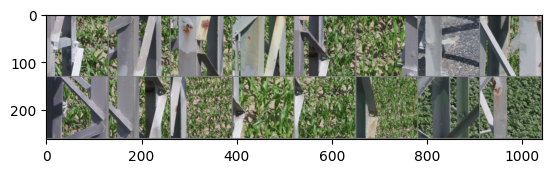

NO_CORROSION NO_CORROSION CORROSION CORROSION CORROSION NO_CORROSION CORROSION CORROSION NO_CORROSION NO_CORROSION CORROSION CORROSION NO_CORROSION NO_CORROSION CORROSION CORROSION


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = input_dataset.classes

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_arg)))

Step 6: Initialize the Classifier Model

In [12]:
net = nn.Sequential(
    nn.Conv2d(3,64,(3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout(p=0.1),
    nn.Conv2d(64,32,(3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout(p=0.1),
    nn.Conv2d(32,16,(3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout(p=0.1),
    nn.Flatten(),
    #voor flatten 16x16x16=4096
    nn.Linear(3136,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.1, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=3136, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

Step 7: Method for Training Step

In [7]:
def training_step(model, train_inputs, train_labels, loss_fn, optimizer, writer, epoch):
    optimizer.zero_grad()
    model_labels = model(train_inputs).flatten()
    loss = loss_fn(model_labels, train_labels.float())
    loss.backward()
    optimizer.step()
    writer.add_scalar(f"{loss_fn.__class__.__name__}/Train", loss, epoch)   

Step 8: Method for Validation Step

In [8]:
@torch.no_grad()
def validation_step(model, val_inputs, val_labels, loss_fn, writer, epoch):
    # Pass the validation data through the model
    model_labels = model(val_inputs).flatten()

    # Compute the loss value
    val_loss = loss_fn(model_labels, val_labels.float())

    # Log the validation loss
    writer.add_scalar(f"{loss_fn.__class__.__name__}/Val", val_loss, epoch)

Step 9: Train and evaluate the model

In [10]:
NUM_OF_EPOCHS = 20
writer = SummaryWriter() 

for epoch in tqdm(range(NUM_OF_EPOCHS)):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')
        training_step(net, inputs, labels, loss_fn, optimizer, writer, epoch)
    for i, data in enumerate(val_loader, 0):
        validation_step(net, inputs, labels, loss_fn, writer, epoch)
        
# Write the weights in a file for using on the test dataset 
torch.save(net.state_dict(), '.\\data5\\patches_classifier\\classifier_weights_20250519')

                

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:31<00:00,  7.60s/it]


Step 10: Test the model and print results in ConfusionMatrix

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
The accuracy is 87.50%


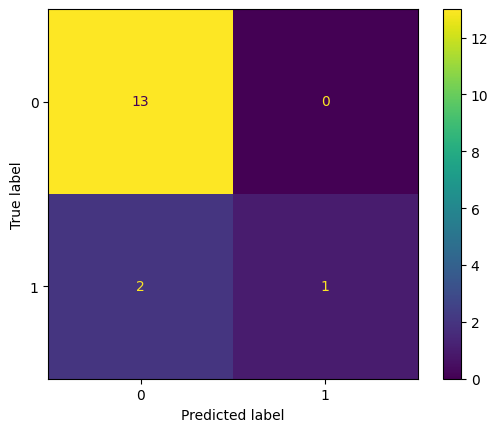

In [24]:
groundtruth_labels = []
predicted_labels = []

net.load_state_dict(torch.load('.\\data5\\patches_classifier\\classifier_weights_20250519'))
net.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        groundtruth_labels.append(labels.float())
        output = net(inputs) #no gradientcalculation during forward pass
        predicted_labels.append(torch.round(output).int().cpu())
    
groundtruth_labels_list = groundtruth_labels[0].flatten().tolist()
predicted_labels_list = predicted_labels[0].flatten().tolist()

print(groundtruth_labels_list)
print(predicted_labels_list)



# Draw the confusion matrix
acc = metrics.accuracy_score(groundtruth_labels_list, predicted_labels_list)
print('The accuracy is {acc:.2f}%'.format(acc=acc*100))

confusion_matrix = metrics.confusion_matrix(groundtruth_labels_list, predicted_labels_list)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()